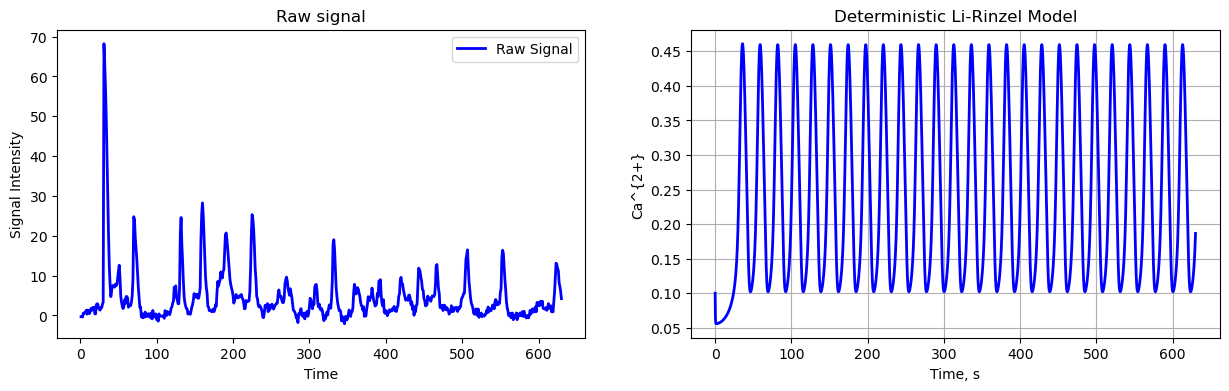

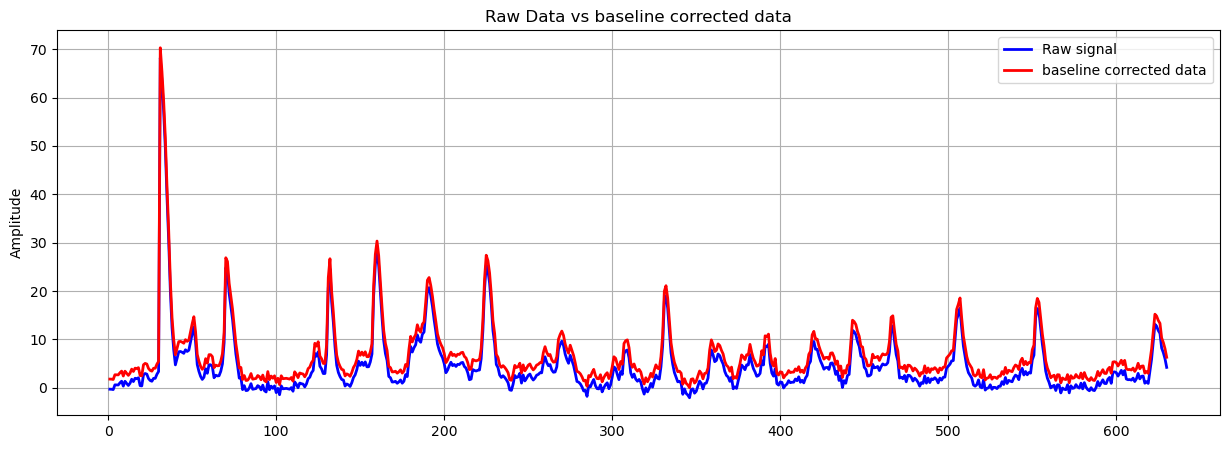

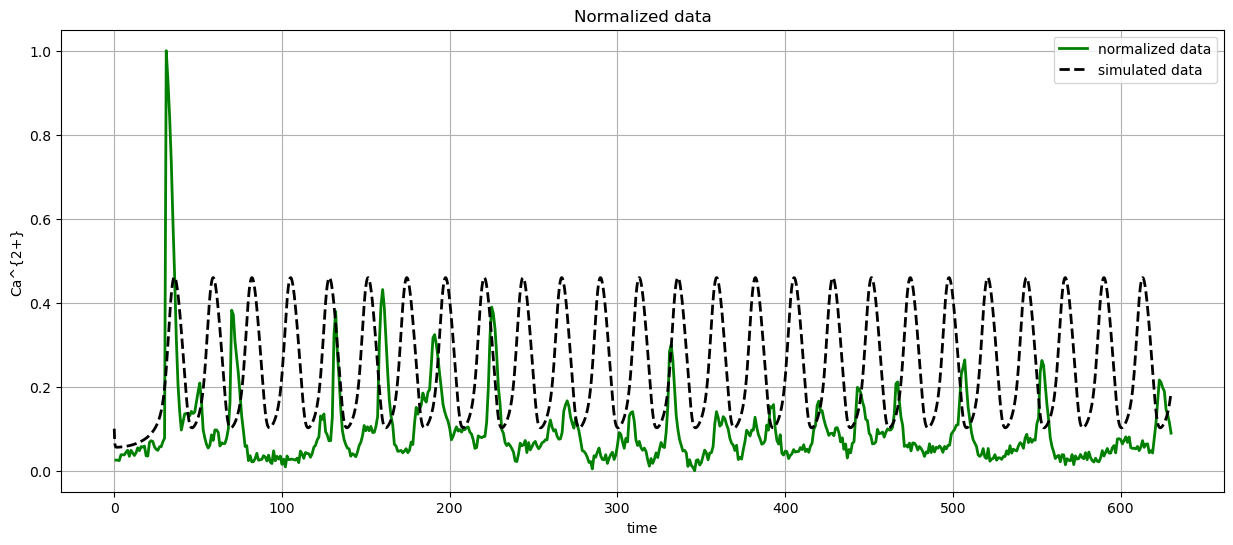

Overall RMSE: 0.191531
Segment 1 optimized v2: 0.0901, optimized v3: 1.0000
Segment 2 optimized v2: 0.0863, optimized v3: 1.0000


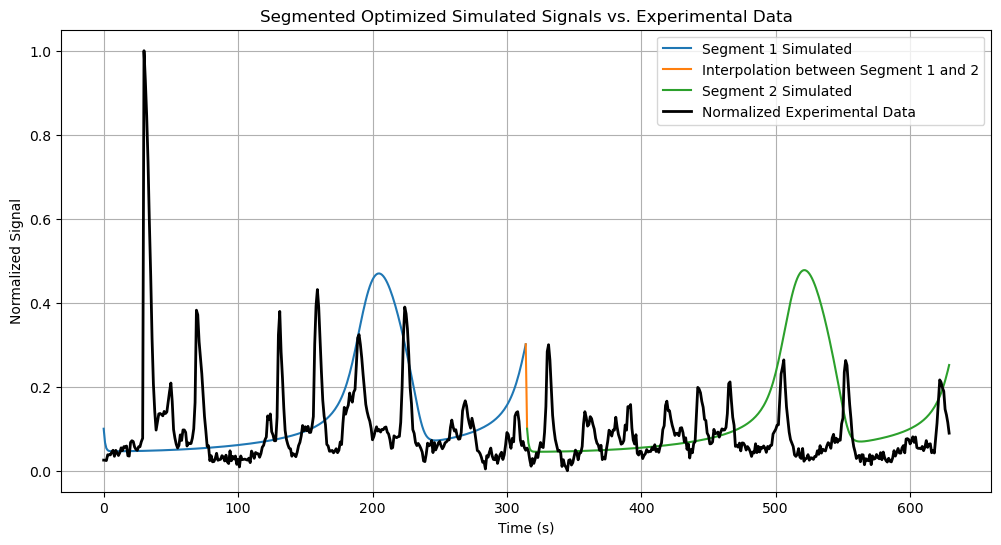

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

#step 1:loading data
Exp_data=pd.read_excel(r'C:\Users\ADMIN\Downloads\Group7_data.xlsx')
Exp_time=Exp_data.iloc[:,0:1]
Exp_sign=Exp_data.iloc[:,1:2]


# step 2: definig Parameters
IP3 = 0.5
v1 = 6
v2 = 0.11
v3 = 0.9
c0 = 2
c1 = 0.185
a2 = 0.2
d1 = 0.13
d2 = 1.049
d3 = 0.9434
d5 = 0.08234
k3 = 0.1
time = np.arange(0, 630.1, 0.2)
dt = 0.1


# Initial conditions
Ca = np.zeros(len(time))
h = np.zeros(len(time))
Ca[0] = 0.1
h[0] = 0.1

#step 3:Deterministic Model-Euler's method
for t in range(1, len(time)):
    CaER = (c0 - Ca[t-1]) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca[t-1] / (Ca[t-1] + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca[t-1]))
    hinf = Q2 / (Q2 + Ca[t-1])
    alphah = hinf / tauh
    
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h[t-1]) - betah * h[t-1]
    dCa = c1 * v1 * pinf**3 * ninf**3 * h[t-1]**3 * (CaER - Ca[t-1]) + c1 * v2 * (CaER - Ca[t-1]) - v3 * (Ca[t-1]**2) / (Ca[t-1]**2 + k3**2)
    
    Ca[t] = Ca[t-1] + dCa * dt
    h[t] = h[t-1] + dh * dt

# Plotting
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(Exp_time,Exp_sign, '-b', linewidth=2,label='Raw Signal',)
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.title('Raw signal')
plt.legend()


plt.subplot(1,2,2)
plt.plot(time, Ca, '-b', linewidth=2)
plt.xlabel('Time, s')
plt.ylabel('Ca^{2+}')
plt.grid(True)
plt.title('Deterministic Li-Rinzel Model')
plt.show()


#step-4:baseline correction and min-max normalization
baseline_corrected = Exp_sign - np.min(Exp_sign)

Exp_sign_min = np.min(baseline_corrected)
Exp_sign_max = np.max(baseline_corrected)
normalized_data = (baseline_corrected - Exp_sign_min) / (Exp_sign_max - Exp_sign_min)


# Plotting the raw, baseline-corrected, and normalized data
plt.figure(figsize=(15, 5))
plt.plot(Exp_time,Exp_sign, '-b', linewidth=2,label='Raw signal')
plt.plot(Exp_time, baseline_corrected, '-r', linewidth=2,label='baseline corrected data')
plt.title('Raw Data vs baseline corrected data')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(Exp_time, normalized_data, '-g', linewidth=2,label='normalized data')
plt.plot(time, Ca, '--k', linewidth=2,label='simulated data')
plt.xlabel('time')
plt.ylabel('Ca^{2+}')
plt.title('Normalized data')
plt.legend()
plt.grid(True)
plt.show()

#step 5:simulation function for varying v2 and v3 segment wise
def simulate_data(v2, v3, time_len):
    Ca_sim = np.zeros(time_len)
    h_sim = np.zeros(time_len)
    Ca_sim[0] = 0.1
    h_sim[0] = 0.1

    for t in range(1, time_len):
        CaER = (c0 - Ca_sim[t-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca_sim[t-1] / (Ca_sim[t-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca_sim[t-1]))
        hinf = Q2 / (Q2 + Ca_sim[t-1])
        alphah = hinf / tauh
        
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h_sim[t-1]) - betah * h_sim[t-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h_sim[t-1]**3 * (CaER - Ca_sim[t-1]) +
                c1 * v2 * (CaER - Ca_sim[t-1]) -
                v3 * (Ca_sim[t-1]**2) / (Ca_sim[t-1]**2 + k3**2))
        
        Ca_sim[t] = Ca_sim[t-1] + dCa * dt
        h_sim[t] = h_sim[t-1] + dh * dt

    return Ca_sim

# step 6:Function to calculate RMSE
def calculate_rmse(exp_data, sim_data):
    exp_data = np.asarray(exp_data)
    sim_data = np.asarray(sim_data)
    
    return np.sqrt(np.mean((exp_data - sim_data) ** 2))

# step 7:Gradient Descent Optimization
def optimize_params(Ca_exp, initial_params, segment_len):
    optimized_params = []
    
    # Iterate over three fixed segments
    for i in range(2):
        start_idx = i * segment_len
        end_idx = start_idx + segment_len

        # Handle the case where the end index exceeds the length of the experimental data
        if end_idx > len(Ca_exp):
            end_idx = len(Ca_exp)

        # Experimental Data Segments
        Ca_exp_segment = Ca_exp[start_idx:end_idx].values
        
        def objective_function(params):
            v2, v3 = params
            Ca_simulated = simulate_data(v2, v3, len(Ca_exp_segment))
            return calculate_rmse(Ca_exp_segment, Ca_simulated)

        initial_guess = [initial_params['v2'], initial_params['v3']]
        
        # RMSE Minimization
        result = minimize(objective_function, initial_guess, bounds=[(0.01, 0.5), (0.1, 1)])

        # Store optimized values
        optimized_params.append(result.x)
        
        # Update parameters for next iteration
        initial_params['v2'], initial_params['v3'] = result.x

    return optimized_params


# step 8:Set parameters for optimization
initial_params = {'v2': 0.11, 'v3': 0.9}  # Initial guesses for v2 and v3
total_length = len(normalized_data)
segment_length = total_length // 2  # Divide data into three segments

optimized_parameters = optimize_params(normalized_data, initial_params, segment_length)

# step 9:Evaluate overall RMSE
overall_rmse = calculate_rmse(normalized_data, simulate_data(initial_params['v2'], initial_params['v3'], len(Exp_time)))
print(f"Overall RMSE: {overall_rmse:.6f}")

#step 10:getting optimized parameters 
for i, params in enumerate(optimized_parameters):
    print(f"Segment {i+1} optimized v2: {params[0]:.4f}, optimized v3: {params[1]:.4f}")

#step 11:Plot the segments
plt.figure(figsize=(12, 6))
cnt = 0
all_time_points = []
all_simulated_data = []

for i in range(len(optimized_parameters)):
    seg_start = i * segment_length
    seg_end = (i + 1) * segment_length
    
    if seg_end > len(normalized_data):  # Check if the end exceeds data length
        seg_end = len(normalized_data)
    
    # Simulate data for this segment
    Ca_sim_segment = simulate_data(optimized_parameters[i][0], optimized_parameters[i][1], seg_end - seg_start)
    
    # Create time points for this segment
    time_segment = np.arange(seg_start, seg_end)
    
    # Store time points and simulated data for interpolation later
    all_time_points.append(time_segment)
    all_simulated_data.append(Ca_sim_segment)
    
    if cnt > 0:
        # Interpolate between the last point of previous segment and the first point of the current one
        prev_seg_end = all_time_points[cnt-1][-1]
        current_seg_start = time_segment[0]
        
        # Linear interpolation between the previous segment end and current segment start
        interp_function = interp1d(
            [prev_seg_end, current_seg_start], 
            [all_simulated_data[cnt-1][-1], Ca_sim_segment[0]], 
            kind='linear'
        )
        
        # Generate interpolated time points for smooth transition
        interp_time_points = np.linspace(prev_seg_end, current_seg_start, 10)
        interp_sim_data = interp_function(interp_time_points)
        
        # Plot interpolated line between segments
        plt.plot(interp_time_points, interp_sim_data, label=f'Interpolation between Segment {i} and {i+1}')
    
    # Plot the actual segment data
    plt.plot(time_segment, Ca_sim_segment, label=f'Segment {i+1} Simulated')

    cnt += 1

    

#step 12:Plotting normalized experimental data
plt.plot(np.arange(0, len(normalized_data)), normalized_data, '-k', linewidth=2, label='Normalized Experimental Data')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Signal')
plt.title('Segmented Optimized Simulated Signals vs. Experimental Data')
plt.legend()
plt.grid(True)
plt.show()
